# MOPITT monthly comparison with maps -- for August 2020

This example loads one MOPITT monthly file and compares to monthly output from a global model CAM-chem. It includes smoothing of the model output to the measurement space with averaging kernels and a priori.

### At the start of a Jupyter notebook you need to import all modules that you will use

In [1]:
# loading
import h5py                                # For loading he5 files
import glob
# Processing
import pandas as pd
import xarray as xr
import numpy as np
from scipy import interpolate              # for vertical interpolation
import time                                # for timing code
#plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs                 # For plotting maps
import cartopy.feature as cfeature         # For plotting maps
from cartopy.util import add_cyclic_point  # For plotting maps

### Functions

In [2]:
def load_and_extract_grid_hdf(filename,varname):
    '''
    This function loads data from MOPITT Level 3 files, which are in hdf format, and returns a data array for the chosen variable.
    
    Function requires:
        filename = the file to open
        varname = variable name to extract from the file. Choices are: column, apriori_col, apriori_surf, pressure_surf, ak_col, apriori_prof
        
    Function Returns:
        ds_masked = a multidimensional xarray DataArray of the chosen MOPITT variable
    '''
    he5_load = h5py.File(filename, mode='r')
    lat = he5_load["/HDFEOS/GRIDS/MOP03/Data Fields/Latitude"][:]
    lon = he5_load["/HDFEOS/GRIDS/MOP03/Data Fields/Longitude"][:]
    alt = he5_load["/HDFEOS/GRIDS/MOP03/Data Fields/Pressure2"][:]
    alt_short = he5_load["/HDFEOS/GRIDS/MOP03/Data Fields/Pressure"][:]
    
    #LAT-LON variables
    if varname=='column':
        data_loaded = he5_load["/HDFEOS/GRIDS/MOP03/Data Fields/RetrievedCOTotalColumnDay"][:]
    elif varname=='apriori_col':
        data_loaded = he5_load["/HDFEOS/GRIDS/MOP03/Data Fields/APrioriCOTotalColumnDay"][:]
    elif varname=='apriori_surf':
        data_loaded = he5_load["/HDFEOS/GRIDS/MOP03/Data Fields/APrioriCOSurfaceMixingRatioDay"][:]
    elif varname=='pressure_surf':
        data_loaded = he5_load["/HDFEOS/GRIDS/MOP03/Data Fields/SurfacePressureDay"][:]
    #LAT-LON-ALT variables    
    elif varname=='ak_col':
        data_loaded = he5_load["/HDFEOS/GRIDS/MOP03/Data Fields/TotalColumnAveragingKernelDay"][:]
    elif varname=='apriori_prof':
        data_loaded = he5_load["/HDFEOS/GRIDS/MOP03/Data Fields/APrioriCOMixingRatioProfileDay"][:]
    
    #DEBEG
    #print(data_loaded.shape)

    # create xarray DataArray
    if (varname=='column' or varname=='apriori_col'
        or varname=='apriori_surf'or varname=='pressure_surf'):
        dataset_new = xr.DataArray(data_loaded, dims=["lon","lat"], coords=[lon,lat])
    elif (varname=='ak_col'):
        dataset_new = xr.DataArray(data_loaded, dims=["lon","lat","alt"], coords=[lon,lat,alt])
    elif (varname=='apriori_prof'):
        dataset_new = xr.DataArray(data_loaded, dims=["lon","lat","alt"], coords=[lon,lat,alt_short])
    
    # missing value -> nan
    ds_masked = dataset_new.where(dataset_new != -9999.)
    he5_load.close()
    
    return ds_masked

In [3]:
def vertical_regrid(input_press, input_values, output_press):
    '''
    This function uses interp1d to regrid vertical layers in a 3D array
    
    Function requires:
        input_press = input pressure levels in hPa and same dimensions as input_values (alt, lat, lon)
        input_values = Dataarray of input values to be regridded (alt, lat, lon)
        output_press = output pressure levels in hPa, dimensions are the same as input values, except for the altitude (new alt, lat, lon)
        
    Function Returns:
        regrid_array = the data regridded to the new pressure levels

    '''
    regrid_array = xr.full_like(output_press, np.nan)
    # Latitude values
    for y in range (input_press.shape[1]):
        #print(y)
        
        # Longitude values
        for x in range (input_press.shape[2]):
            #print(x)
            xx = input_press.isel(lat=y, lon=x)
            yy = input_values.isel(lat=y, lon=x)
            f = interpolate.interp1d(xx, yy, fill_value="extrapolate")
            xnew = output_press.isel(lat=y, lon=x)
            regrid_array[x, y, :] = f(xnew)
            
    return regrid_array

### Load Measurements
MOPITT CO V9 joint product, L3 gridded 1x1.
Available from https://doi.org/10.5067/TERRA/MOPITT/MOP03JM.009

In [4]:
file = '/glade/work/buchholz/data/MOPITT/MOP03JM-202008-L3V95.9.3.he5'

In [5]:
data_array = load_and_extract_grid_hdf(file, "column")

In [7]:
#surface pressure
sat_psurf  = load_and_extract_grid_hdf(file, "pressure_surf")

In [8]:
# load column and surface a priori
prior_col_array = load_and_extract_grid_hdf(file, "apriori_col")

In [9]:
# load profile a priori and surface
# The surface layer in MOPITT files is saved separately to the other 9 layers
prior_prof_array = load_and_extract_grid_hdf(file, "apriori_prof")
prior_surf = load_and_extract_grid_hdf(file, "apriori_surf")

In [10]:
# averaging kernel
ak_array = load_and_extract_grid_hdf(file, "ak_col")

### Setup a 3D measurement pressure array

In [11]:
# broadcast 9 levels 900 to 100 hPa repeated everywhere
dummy, press_dummy_arr = xr.broadcast(prior_prof_array,prior_prof_array.alt)

In [12]:
# create array to hold 9 regular spaced, plus the floating surface pressure
sat_pressure_array = xr.full_like(ak_array, np.nan)
sat_pressure_array[:,:,0] = sat_psurf
sat_pressure_array[:,:,1:10] = press_dummy_arr

#DEBUG
#print(sat_pressure_array.isel(lat=-45, lon=-80))

In [13]:
#Correct for where MOPITT surface pressure <900 hPa
#calculate pressure differences relative to the surface layer
dp = xr.full_like(ak_array, np.nan)
dp[:,:,9] = 1000
for z in range (0, 9):
    dp[:,:,z] = sat_pressure_array[:,:,0] - sat_pressure_array[:,:,z+1]
    
#DEBUG
#print(dp.isel(lat=-45, lon=-80))

#Create an array with repeated surface values at all levels to replace in equivalent position in parray if needed
psurfarray = xr.full_like(ak_array, np.nan)
for z in range (0, 10):
    psurfarray[:,:,z] = sat_psurf
    
#Add fill values below "true" surface layer
new_pressure_array = sat_pressure_array.copy()
new_pressure_array = new_pressure_array.where(dp>0)

#replace the lowest pressure with surface pressure
new_pressure_array = psurfarray.where((dp>0) & (dp<100),new_pressure_array)

#DEBUG
#print(new_pressure_array.isel(lat=-45, lon=-80))

In [14]:
# Model layer values are averages for the whole box, centred at an altitude,
# while MOPITT values are averages described for the whole box above level value.
# Therefore, we need to interp MOPITT pressures to mid-box locations
pinterp = xr.full_like(ak_array, np.nan)
pinterp[:,:,9] = 87.
for z in range (0, 9):
    pinterp[:,:,z] = new_pressure_array[:,:,z] - (new_pressure_array[:,:,z]-new_pressure_array[:,:,z+1])/2

#DEBUG
#print(pinterp.isel(lat=-45, lon=-80))

### Setup combined a priori array

In [15]:
# MOPITT surface values are stored separately to profile values because of the floating surface pressure.
# So, for the smoothing calculations, need to combine surface and profile
# Repeat surface a priori values at all levels to replace if needed
apsurfarray = xr.full_like(ak_array, np.nan)
for z in range (0, 10):
    apsurfarray[:,:,z] = prior_surf
    
#DEBUG
#print(apsurfarray.isel(lat=-45, lon=-80))

aparray = xr.full_like(ak_array, np.nan)
aparray[:,:,0] = prior_surf
aparray[:,:,1:10] = prior_prof_array
aparray = aparray.where(dp>0)
aparray = apsurfarray.where((dp>0) & (dp<100),aparray)

#DEBUG
#print(aparray.isel(lat=-45, lon=-80))

### Define the directories and file of interest for your model results.

In [16]:
# Simulation of CAM-chem for WRF-Chem boundaries
# https://doi.org/10.5065/NMP7-EP60

result_dir = "/glade/campaign/acom/acom-da/CAM_chem_output/fmerra.2.1003.FCSD.f09.qfedcmip.56L.001.branch02/atm/hist/"
files = "fmerra.2.1003.FCSD.f09.qfedcmip.56L.001.branch02.cam.h0.2020-08.nc"
#the netcdf file is now held in an xarray dataset named 'nc_load' and can be referenced later in the notebook
nc_load = xr.open_mfdataset(result_dir+files,combine='by_coords',concat_dim='time')

#to see what the netCDF file contains, just call the variable you read it into
#nc_load


In [17]:
# Convert longitudes to -180 to 180
nc_load = nc_load.assign_coords(lon=(((nc_load.lon + 180) % 360) - 180)).sortby('lon')

#DEBUG
#nc_load

### Extract the variable of choice

In [18]:
#extract variable
var_sel = nc_load['CO'].load()/1e-09
date = var_sel.coords['time']
var_sel = var_sel.squeeze()

In [19]:
# Model pressure values
psurf = nc_load['PS'].load().squeeze()
# model pressure is in Pa so convert to hPa
pdel = nc_load['PDELDRY'].load()/100
pdel = pdel.squeeze()

In [20]:
# If PDELDRY was not saved, you can manually calculate the delta pressure
# using hybrid coordinate variable definitons for the interfaces (edges)
# https://www2.cesm.ucar.edu/models/atm-cam/docs/usersguide/node25.html
# model pressure is in Pa
hyai = nc_load['hyai'].load()
hybi = nc_load['hybi'].load()
p0 = nc_load['P0'].load()
lev = var_sel.coords['lev']
num_lev = lev.shape[0]

# Initialize pressure edge arrays
mod_press_low = xr.zeros_like(var_sel)
mod_press_top = xr.zeros_like(var_sel)

# Calculate pressure edge arrays
# CAM-chem layer indices start at the top and end at the bottom
for i in range(num_lev):
    mod_press_top[i,:,:] = hyai[i]*p0 + hybi[i]*psurf
    mod_press_low[i,:,:] = hyai[i+1]*p0 + hybi[i+1]*psurf

# Delta P in hPa
mod_deltap = (mod_press_low - mod_press_top)/100
# CHECK ----->
# Calculated in python should be within 3 to 4 decimal places of model calculated PDELDRY
# print(mod_deltap[0,:,0,0].values, " versus PDELDRY ", pdel[0,:,0,0].values)

# Pressure mid-layer values
mod_press_mid = (mod_press_top + mod_press_low)/200


### Regrid model to MOPITT horizontal grid
Horizontal regridding can have many options. Currently using xarray interp.

In [21]:
# linear interp
tracer_regrid = var_sel.interp(coords=dict(lat=data_array.lat, lon=data_array.lon), method='linear')
mod_deltap_regrid = pdel.interp(coords=dict(lat=data_array.lat, lon=data_array.lon), method='linear')
psurf_regrid = psurf.interp(coords=dict(lat=data_array.lat, lon=data_array.lon), method='linear')
model_pressure_regrid = mod_press_mid.interp(coords=dict(lat=data_array.lat, lon=data_array.lon), method='linear')

### Vertical interpolate model grid to MOPITT vertical layers

In [22]:
start = time.perf_counter()
model_vert_regrid = vertical_regrid(model_pressure_regrid, tracer_regrid, pinterp)
end = time.perf_counter()
print('This took '+ str((end-start)/60) + ' minutes to run')

#DEBUG
#print(model_vert_regrid.shape)

This took 1.0643710848254462 minutes to run


### Consistency check: plot profile
Spot-check that the interpolation and AK application is doing what we think it is doing.

In [23]:
def profile_plot(x,y,color_choice,label_string,linewidth,marker):
    plt.plot(x, y, marker, label=label_string,
         color=color_choice,
         markersize=10, linewidth=linewidth,
         markerfacecolor=color_choice,
         markeredgecolor='grey',
         markeredgewidth=1)

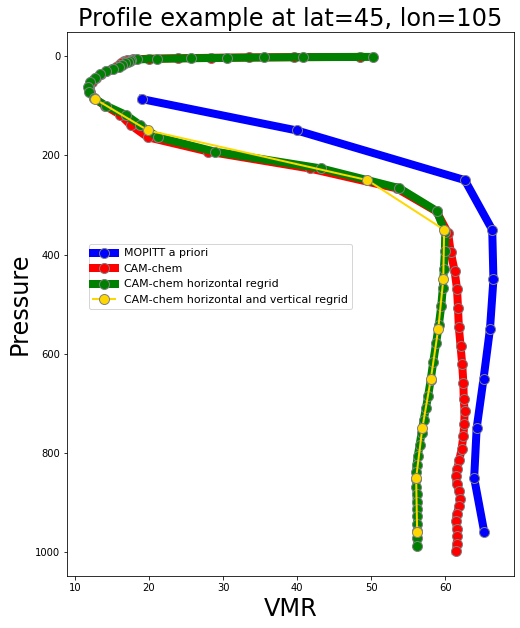

In [24]:
plt.figure(figsize=(8,10))
ax = plt.axes()
ax.invert_yaxis()

#-------------------| variable |------------------------| pressure |---------
profile_plot(aparray.isel(lat=45, lon=105), pinterp.isel(lat=45, lon=105), 'blue','MOPITT a priori',8,'-ok')
profile_plot(var_sel.isel(lat=45, lon=105), mod_press_mid.isel(lat=45, lon=105), 'red','CAM-chem',8,'-ok')
profile_plot(tracer_regrid.isel(lat=45, lon=105), model_pressure_regrid.isel(lat=45, lon=105), 'green','CAM-chem horizontal regrid',8,'-ok')
profile_plot(model_vert_regrid.isel(lat=45, lon=105), pinterp.isel(lat=45, lon=105), 'gold','CAM-chem horizontal and vertical regrid',2,'-ok')


#titles
plt.title('Profile example at lat=45, lon=105',fontsize=24)        
plt.xlabel('VMR',fontsize=24)
plt.ylabel('Pressure',fontsize=24)

# legend
plt.legend(bbox_to_anchor=(0.65, 0.48),loc='lower right',fontsize=11)

plt.show() 

### Convert to total column for comparison

Convert base model and regridded model values to total column amounts in case needed for comparison. TA good consistency check if needed at a later stage.

In [25]:
#-------------------------------
#CONSTANTS and conversion factor
#-------------------------------
NAv = 6.0221415e+23                       #--- Avogadro's number
g = 9.81                                  #--- m/s - gravity
MWair = 28.94                             #--- g/mol
xp_const = (NAv* 10)/(MWair*g)*1e-09      #--- scaling factor for turning vmr into pcol
                                          #--- (note 1*e-09 because in ppb)

In [26]:
var_tcol = xr.dot(pdel, xp_const*var_sel, dims=["lev"])
var_tcol_regrid = xr.dot(mod_deltap_regrid, xp_const*tracer_regrid, dims=["lev"])


### Apply MOPITT AK
Smooth model data to measurement space according to the User Guide:
https://www2.acom.ucar.edu/sites/default/files/documents/v9_users_guide_20220203.pdf

C<sub>smooth</sub> = C<sub>prior</sub> + AK(x<sub>model</sub>−x<sub>prior</sub>)

C = column
x = profile

Note MOPITT AKs are applied to log<sub>10</sub>(VMR)


In [27]:
log_ap = xr.ufuncs.log10(aparray)
log_model = xr.ufuncs.log10(model_vert_regrid)
diff_array = log_model-log_ap

In [28]:
ak_appl = ak_array * diff_array
smoothed_model = prior_col_array + np.sum(ak_appl, axis=2)

#DEBUG
# print(smoothed_model)

### Difference
The smoothed model - observations array

In [29]:
tcol_diff = smoothed_model - data_array

## Plot

### Plot the map comparisons

In [30]:
month_title = 'August 2020'

In [31]:
# Add cyclic point to avoid white line over Africa
lon_model = var_sel.lon

In [32]:
var_tcol_cyc, lon_cyc = add_cyclic_point(var_tcol, coord=lon_model)

In [33]:
#Sub-plots function
def map_subplot(lon,lat,var,contours,colormap,labelbar,position1,position2,title):
    mapplot = axs[position1,position2].contourf(lon,lat,var,contours,cmap=colormap,extend=labelbar)
    axs[position1,position2].coastlines()
    #gridlines
    gl = axs[position1,position2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='grey', 
                                            linewidth=2, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 42, 'color': 'gray'}
    gl.ylabel_style = {'size': 42, 'color': 'gray'}
    #longitude limits in degrees
    #axs[position1,position2].set_xlim(-135,-65)
    #latitude limits in degrees
    axs[position1,position2].set_ylim(-70,70)
    # add coastlines
    axs[position1,position2].add_feature(cfeature.COASTLINE)
    axs[position1,position2].add_feature(cfeature.LAKES)
    axs[position1,position2].add_feature(cfeature.BORDERS)
    
    # add title
    axs[position1,position2].set_title(title, fontsize=56)

    return mapplot

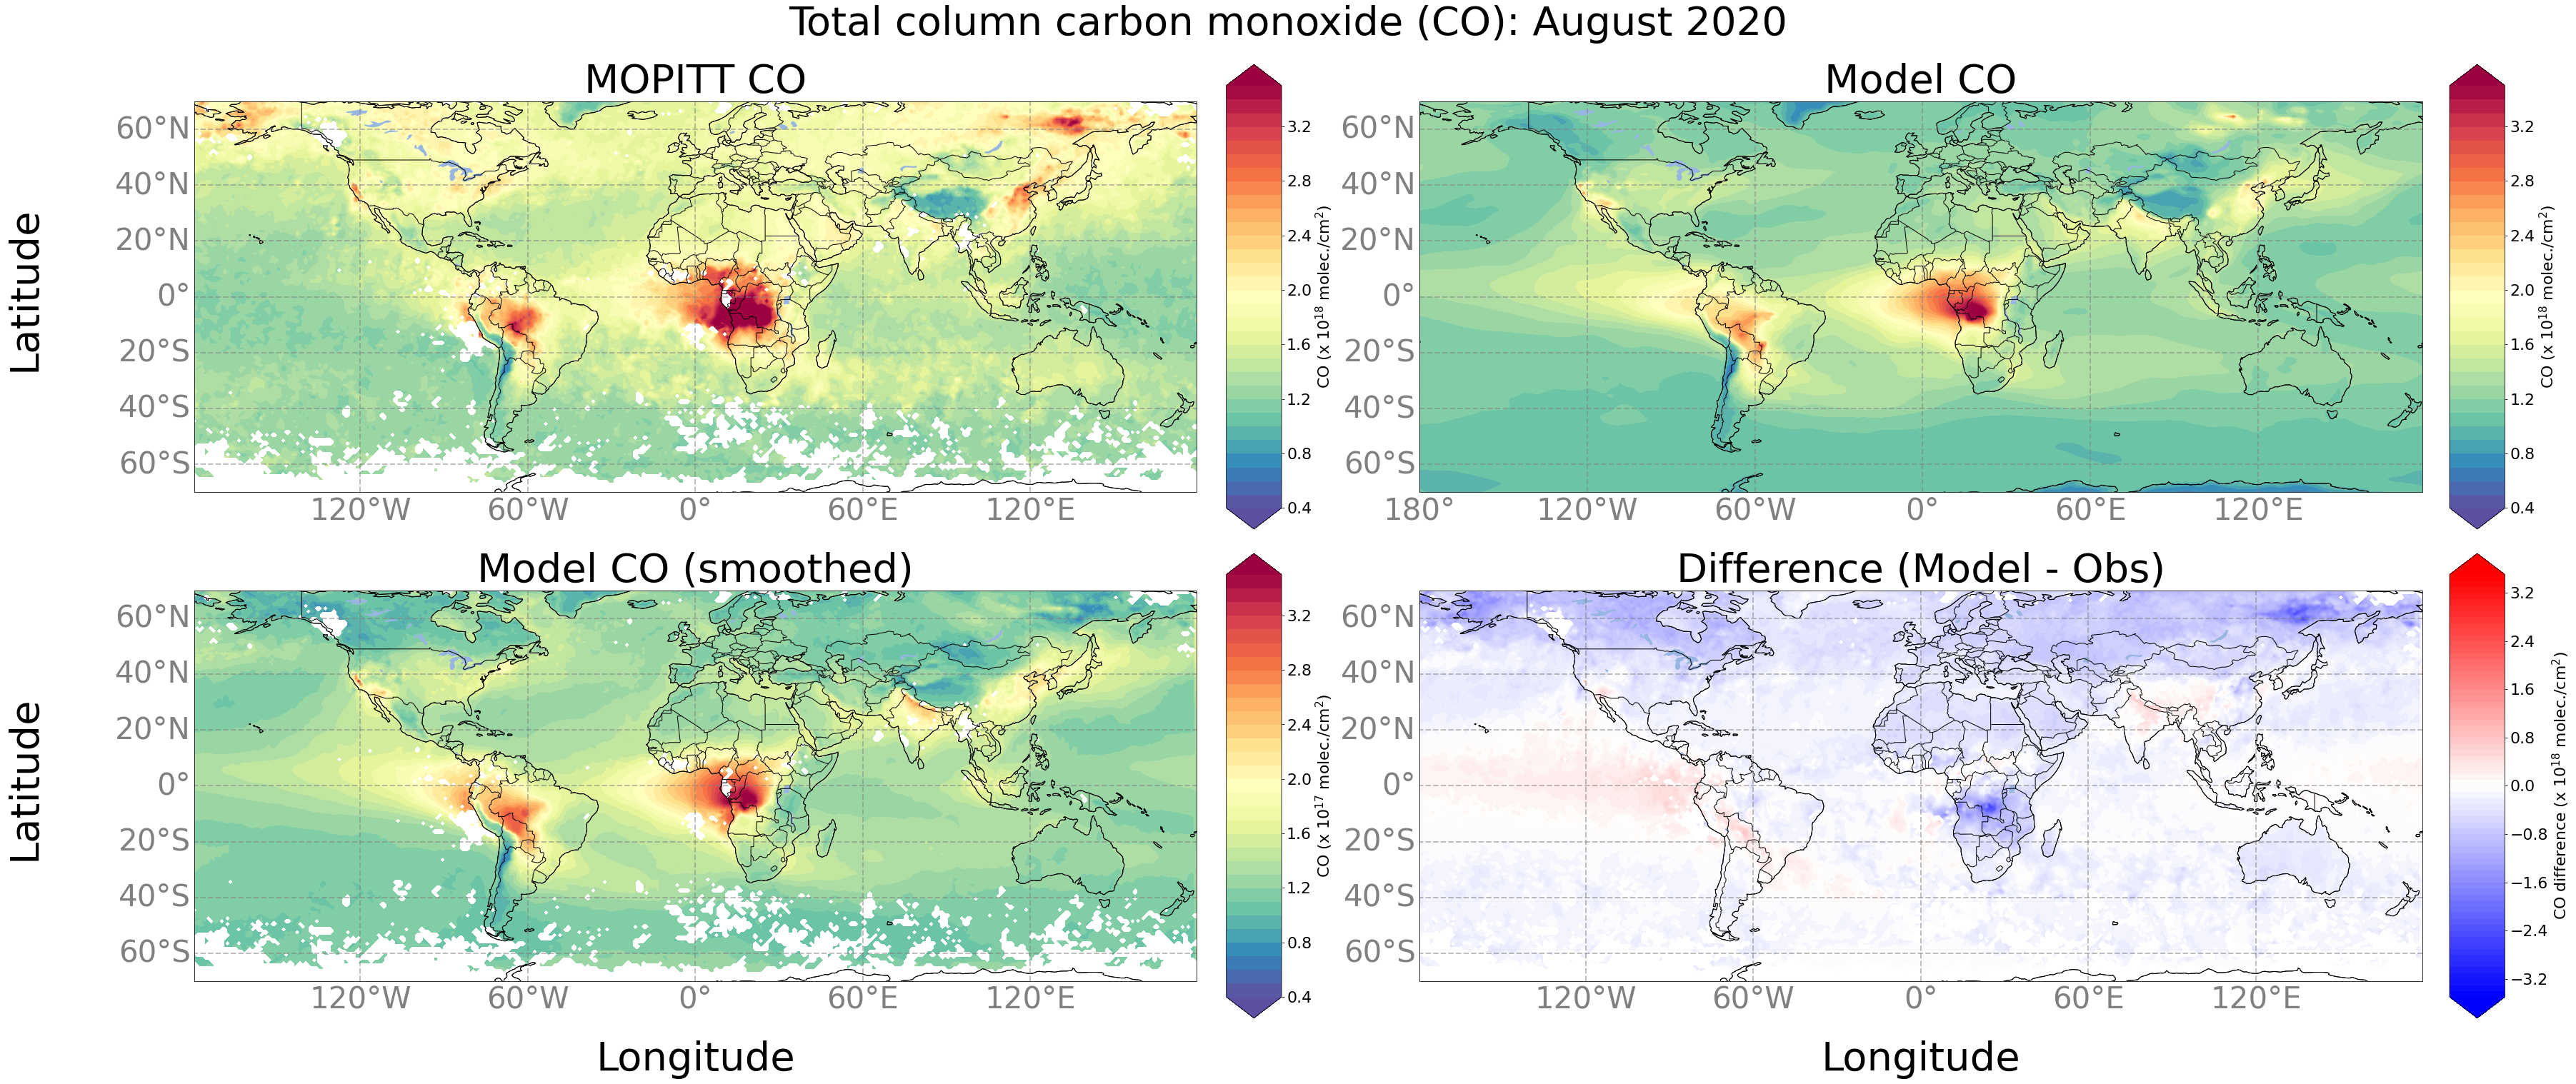

In [34]:
#-----------------columns, rows
fig, axs = plt.subplots(2,2,figsize=(50,21),
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        constrained_layout=True)

fig.set_constrained_layout_pads(w_pad=4 / 72, h_pad=4 / 72, hspace=0, wspace=0)
fig.suptitle('Total column carbon monoxide (CO): '+month_title, fontsize=56)

#------------------ Create the plots
#define contour levels
clev = np.arange(0.4, 3.6, 0.1)

# Plot MOPITT columns
x = 0
y = 0
cbar_set = map_subplot(data_array.lon,data_array.lat,data_array.transpose()/1e18,clev,'Spectral_r','both',x,y,'MOPITT CO')
# Colorbar definitions
cb = fig.colorbar(cbar_set, ax=axs[x,y], shrink=0.95)
cb.set_label(label='CO (x $10^{18}$ molec./cm$^2$)', fontsize=22)
cb.ax.tick_params(labelsize=22)

# Plot original model columns
x = 0
y = 1
cbar_set = map_subplot(var_tcol.lon,var_tcol.lat,var_tcol/1e18,clev,'Spectral_r','both',x,y, 'Model CO')
# Colorbar definitions
cb = fig.colorbar(cbar_set, ax=axs[x,y], shrink=0.95)
cb.set_label(label='CO (x $10^{18}$ molec./cm$^2$)', fontsize=22)
cb.ax.tick_params(labelsize=22)

# Plot CAM-chem columns smooth
x = 1
y = 0
cbar_set = map_subplot(smoothed_model.lon,smoothed_model.lat,smoothed_model.transpose()/1e18,clev,'Spectral_r','both',x,y,'Model CO (smoothed)')
# Colorbar definitions
cb = fig.colorbar(cbar_set, ax=axs[x,y], shrink=0.95)
cb.set_label(label='CO (x $10^{17}$ molec./cm$^2$)', fontsize=22)
cb.ax.tick_params(labelsize=22)
    
# Plot CAM-chem -- MOPITT diff
#new contour levels
clevII = np.arange(-3.5, 3.6, 0.1)
x = 1
y = 1
cbarII_set = map_subplot(tcol_diff.lon,tcol_diff.lat,tcol_diff.transpose()/1e18,clevII,'bwr','both',x,y,'Difference (Model - Obs)')
# Colorbar definitions
cbII = fig.colorbar(cbarII_set, ax=axs[x,y], shrink=0.95)
cbII.set_label(label='CO difference (x $10^{18}$ molec./cm$^2$)', fontsize=22)
cbII.ax.tick_params(labelsize=22)


#------------------ Axes titles
# x-axis
for i in range(2):
    axs[1,i].text(0.50, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=axs[1,i].transAxes, fontsize=56)

# y-axis
for j in range(2):
    axs[j,0].text(-0.15, 0.52, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axs[j,0].transAxes, fontsize=56)
    

#plt.show()
plt.savefig('comparison'+month_title+'.png')